In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
barcodes_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/mincl.10_bothConds.False_p0.1/clones.dendro_dt_0.6__nuc.clust/"


clone_col = "den_clust"
atac_col = "cluster_labels"

# config
N_DONORS = 2
input_cond = "Input"

# params
min_clone_size = 10
p_thresh = 0.1 


#conds_sep = False

counts_f = ""

In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")

sim_all_dir = join(all_dir, "shuffle")
sim_sep_dir = join(sep_dir, "shuffle")

if not exists(all_dir):
    os.mkdir(all_dir)
if not exists(sep_dir):
    os.mkdir(sep_dir)
if not exists(sim_all_dir):
    os.mkdir(sim_all_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
    if not exists(join(donor_out[d], "shuffle")):
        os.mkdir(join(donor_out[d], "shuffle"))

In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

In [5]:
barcodes_in = {}
for d in np.arange(N_DONORS):
    barcodes_in[d] = pd.read_csv(join(barcodes_dir,f"donor{d}.clones_dendro.csv"), index_col=0)

    barcodes_in[d][clone_col] = str(d) + "_" + barcodes_in[d][clone_col]
    
barcodes_in[d].head()

,size,donor,den_clust
lineage,,,
1_32,63,1,1_C0
1_2,552,1,1_C0
1_8,313,1,1_C0
1_4,450,1,1_C1
1_24,140,1,1_C1


In [6]:
#counts_df = pd.read_csv(counts_f, sep="\t")

## Load cells_meta

In [7]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]


## Map the new group to cells_meta

In [8]:
cells_meta[clone_col] = cells_meta.apply(lambda x: barcodes_in[int(x["donor"])].loc[x["name"], clone_col] , axis=1)
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,den_clust
Control_AAACGAAAGAATCAGT-1,Control,1972,1972,6432,1259,31,19,266,1066,3791,...,2211,1942,AAACGAAAGAATCAGT-1_Control,Control_AAACGAAAGAATCAGT-1,4,1,Control,1_4,eosonophil,1_C1
Control_AAACGAAAGCATACCT-1,Control,2674,2674,11858,1937,51,34,549,3102,6185,...,3311,2750,AAACGAAAGCATACCT-1_Control,Control_AAACGAAAGCATACCT-1,30,1,Control,1_30,MPP/CMP/GMP C,1_C1
Control_AAACGAAAGCGAGAAA-1,Control,1939,1939,7365,1097,25,27,275,2184,3757,...,2112,1838,AAACGAAAGCGAGAAA-1_Control,Control_AAACGAAAGCGAGAAA-1,27,0,Control,0_27,MPP/CMP/GMP C,0_C1
Control_AAACGAAAGTACAGAT-1,Control,862,862,4095,861,16,16,230,771,2201,...,1441,1317,AAACGAAAGTACAGAT-1_Control,Control_AAACGAAAGTACAGAT-1,4,0,Control,0_4,erythroid,0_C0
Control_AAACGAAAGTACAGTA-1,Control,1775,1775,8088,1091,27,27,369,2157,4417,...,2385,2085,AAACGAAAGTACAGTA-1_Control,Control_AAACGAAAGTACAGTA-1,21,1,Control,1_21,eosonophil,1_C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Input_TTTGTGTGTTTCTTAC-1,Input,3585,3585,17067,3257,63,80,461,8097,5109,...,3738,2899,TTTGTGTGTTTCTTAC-1_Input,Input_TTTGTGTGTTTCTTAC-1,11,0,Input,0_11,MPP/CMP/GMP B,0_C1
Input_TTTGTGTTCCTGAAAC-1,Input,4362,4362,30427,8323,84,99,799,12146,8976,...,5839,4144,TTTGTGTTCCTGAAAC-1_Input,Input_TTTGTGTTCCTGAAAC-1,7,0,Input,0_7,MEP,0_C1
Input_TTTGTGTTCGGGAAAC-1,Input,8047,8047,40114,14032,169,160,1561,10102,14090,...,9421,5890,TTTGTGTTCGGGAAAC-1_Input,Input_TTTGTGTTCGGGAAAC-1,25,0,Input,0_25,MPP/CMP/GMP B,0_C1
Input_TTTGTGTTCGGGACAA-1,Input,3303,3303,22721,4421,43,84,546,11692,5935,...,4303,3323,TTTGTGTTCGGGACAA-1_Input,Input_TTTGTGTTCGGGACAA-1,6,1,Input,1_6,erythroid,1_C2


## Filter for input only

In [9]:
cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
cells_meta.head()

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,den_clust
Input_AAACGAAAGATATGAC-1,Input,2858,2858,29954,4853,67,103,626,19521,4784,...,3172,2505,AAACGAAAGATATGAC-1_Input,Input_AAACGAAAGATATGAC-1,23,1,Input,1_23,MPP/CMP/GMP,1_C2
Input_AAACGAAAGTAATGTG-1,Input,6511,6511,32111,9018,96,122,1319,11232,10324,...,7161,4861,AAACGAAAGTAATGTG-1_Input,Input_AAACGAAAGTAATGTG-1,1,1,Input,1_1,MPP/CMP/GMP,1_C1
Input_AAACGAAAGTAGTCGG-1,Input,7561,7561,37923,12542,147,162,1705,10189,13178,...,8960,5447,AAACGAAAGTAGTCGG-1_Input,Input_AAACGAAAGTAGTCGG-1,5,1,Input,1_5,MPP/CMP/GMP B,1_C2
Input_AAACGAACACATTGCA-1,Input,6920,6920,46206,12553,148,184,1239,16880,15202,...,10041,5539,AAACGAACACATTGCA-1_Input,Input_AAACGAACACATTGCA-1,0,1,Input,1_0,CLP,1_C1
Input_AAACGAACACGCTCAG-1,Input,5875,5875,38973,7584,162,150,973,19691,10413,...,7103,4786,AAACGAACACGCTCAG-1_Input,Input_AAACGAACACGCTCAG-1,1,0,Input,0_1,MPP/CMP/GMP,0_C2


<AxesSubplot:xlabel='den_clust', ylabel='count'>

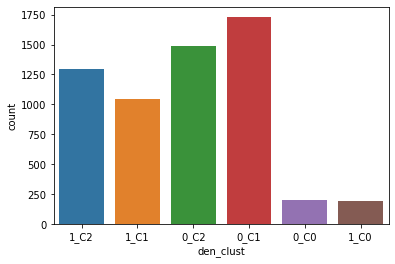

In [10]:
sns.countplot(data=cells_meta,x=clone_col)

## construct the clone_groups and atac_cl_groups

In [11]:
# def run_hypergeo(groups, clones, atac_cl):
    
#     #p(k,M,n,N) = (n choose k)((M-n)choose(N-k))/(MchooseN)
#     #pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
#                                    #for max(0, N - (M-n)) <= k <= min(n, N)

#     # M: Total number of cells
#     # n: Number of cells in the atac cluster (group population)
#     # N: Number of cells in clone (the draw)
#     # x: Number of cells in specific clone and cluster
#     enrichment_df = pd.DataFrame(index=clones,
#                                  columns=atac_cl, dtype=np.float128)

#     M = groups["count"].sum()
#     for cl in clones:
#         for atac in atac_cl:     
#             n = groups[groups[atac_col]==atac]["count"].sum()
#             N = groups[groups[clone_col]==cl]["count"].sum()

#             x = groups[((groups[clone_col]==cl)& (groups[atac_col]==atac))]["count"].sum()

#             # rv = hypergeom(M, n, N)
#             prb = 1 - hypergeom.cdf(x, M, n, N)
#             enrichment_df.loc[cl, atac] = prb
#     return enrichment_df


# def pval_correct(enrichment_df, p_thresh ):
#     reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(), alpha=p_thresh, method="fdr_bh")

#     nrows, ncols = enrichment_df.shape
#     reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(),
#                                                             alpha=p_thresh, method="fdr_bh")
#     pvals_corrected = np.reshape(pvals_corrected, [nrows,ncols])
#     return pvals_corrected

# def create_enrichment(groups, clones, atac_cl):
#     enrichment_df = run_hypergeo(groups, clones, atac_cl)
#     pvals_corrected = pval_correct(enrichment_df, p_thresh )
#     bh_enrichment_df = enrichment_df.copy()
#     bh_enrichment_df.loc[:,:] = pvals_corrected
#     #print('bh_enrichment_df', bh_enrichment_df.head())
#     return bh_enrichment_df


# def create_output_df(bh_enrichment_df, sizes):
#     output_df = pd.DataFrame(index=sizes.index)
#     #output_df = pd.DataFrame(index=bh_enrichment_df.index)
#     output_df["significant clusters"] = ""
#     output_df["size"] = sizes
#     output_df["min_significance"] = None

#     sig_results = []
#     sig_order = []
#     #for ind, val in bh_enrichment_df.loc[sizes.index].iterrows():
#     for ind, val in bh_enrichment_df.iterrows():
#         passed = val[val<p_thresh].index.values
#         if len(passed)>0:
#             output_df.loc[ind, "significant clusters"] = ";".join([str(x) for x in passed])
#             output_df.loc[ind, "min_significance"] = min(val)
#            # sig_results.append((ind, passed))
#     output_df.loc[:, bh_enrichment_df.columns] = bh_enrichment_df.loc[output_df.index]
#     #print('output df before filter')
#     #print(output_df.head())
#     output_df = output_df.sort_values("min_significance")

#     output_df = output_df.loc[~(output_df["min_significance"].isnull())]
#     print('output df after filter')
#     print(output_df.head())
#     #output_df.to_csv(out_f, sep=",")
#     output_df=output_df.sort_values("size", ascending=True)
#     bh_enrichment_df[bh_enrichment_df>p_thresh] = 1
#     bh_enrichment_df[bh_enrichment_df==0] = min(p_thresh,min(set((bh_enrichment_df.values).flatten())-{0})) # Set to the next min, or p_thresh, whichever is smaller
#     return output_df, bh_enrichment_df

# def pipeline_groups_hypergeo(groups, clones, atac_cl, sizes):
#     bh_enrichment_df = create_enrichment(groups, clones, atac_cl)
#     output_df, bh_enrichment_df = create_output_df(bh_enrichment_df, sizes=sizes)
#     return output_df, bh_enrichment_df



## A) Loop through donor and run 

['0_C0' '0_C1' '0_C2']
['CLP' 'DC' 'MEP' 'MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP C'
 'MPP/CMP/GMP D' 'eosonophil' 'erythroid' 'macrophage' 'meg/erythroid'
 'monocyte' 'neutrophil' 'neutrophil B']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)
ic| len(global_min): 1000
ic| len(clone_min): 3
ic| len(clone_min): 3
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all): 3


Number of groups below p-val significance: 0
Number of groups below p-val significance: 0
clone all
axs 1
curr_thresh 6.2219118746043026294e-12
curr_thresh 0.0
curr_thresh 0.0
['1_C0' '1_C1' '1_C2']
['CLP' 'DC' 'MEP' 'MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP C'
 'MPP/CMP/GMP D' 'eosonophil' 'erythroid' 'macrophage' 'meg/erythroid'
 'monocyte' 'neutrophil' 'neutrophil B']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)
ic| len(global_min): 1000
ic| len(clone_min): 3
ic| len(clone_min): 3
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all): 3


Number of groups below p-val significance: 0
Number of groups below p-val significance: 0
clone all
axs 1
curr_thresh 0.0
curr_thresh 0.0
curr_thresh 0.0


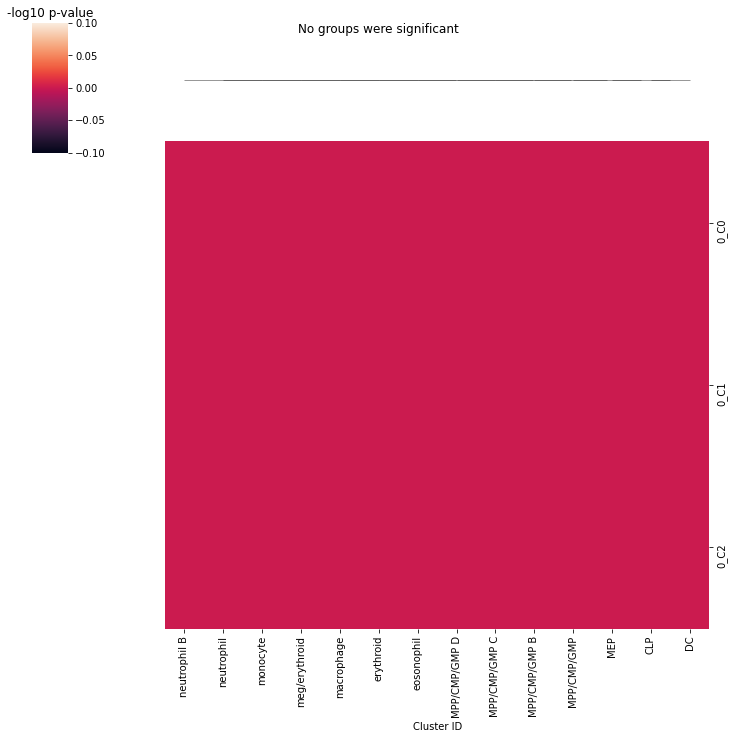

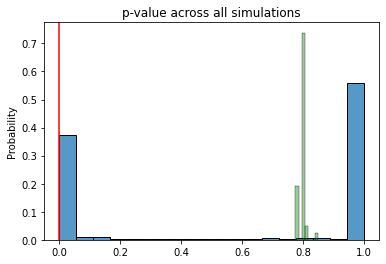

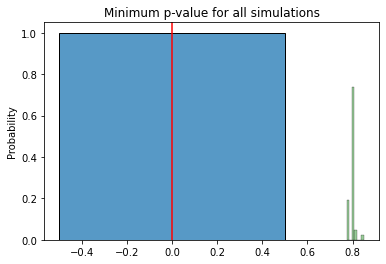

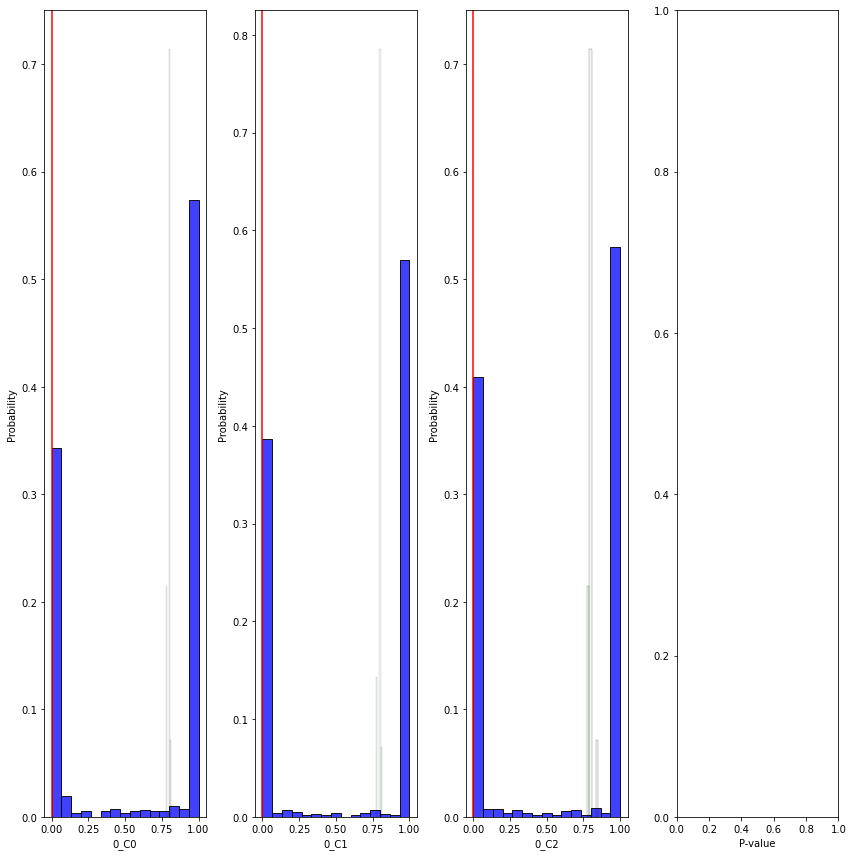

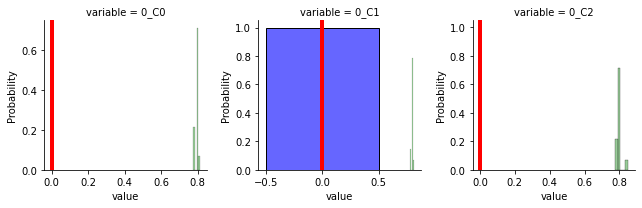

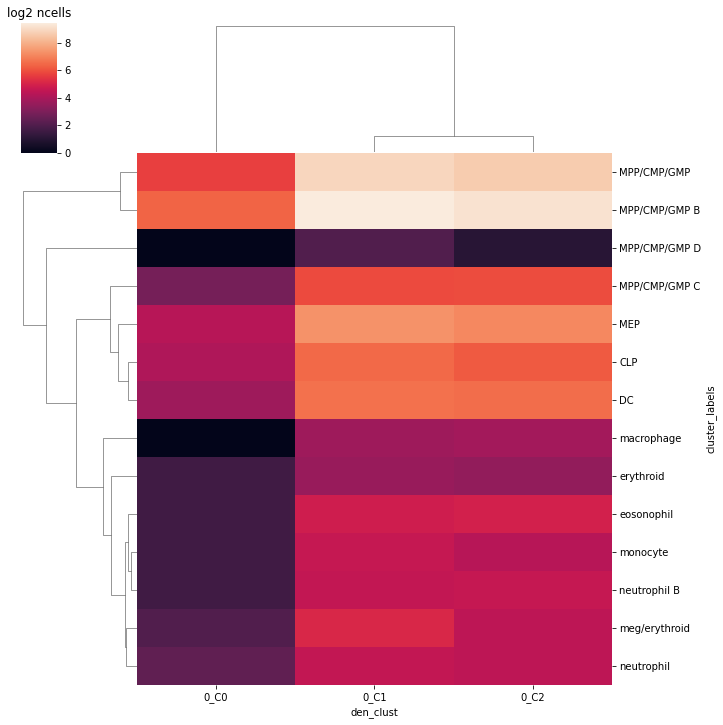

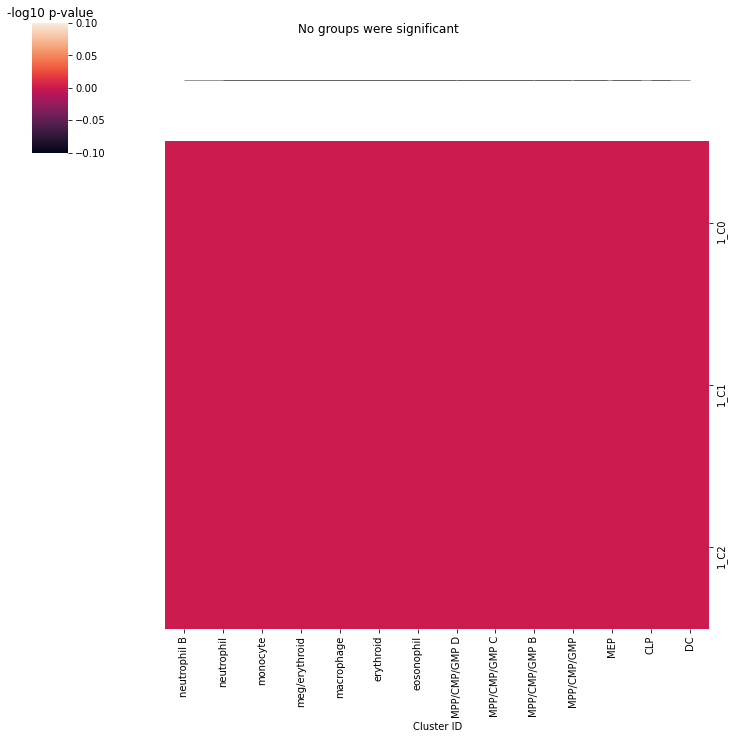

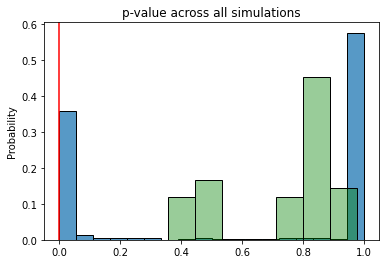

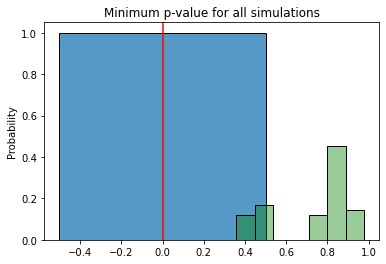

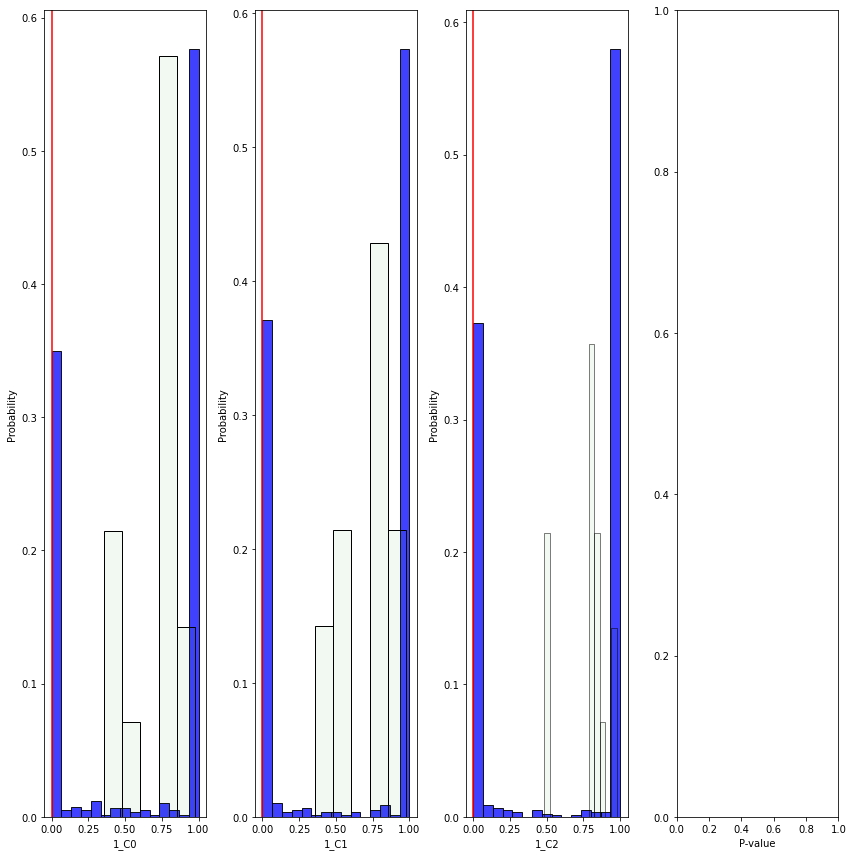

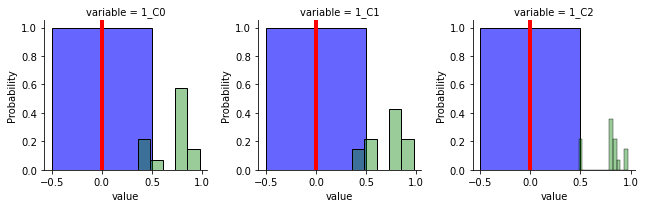

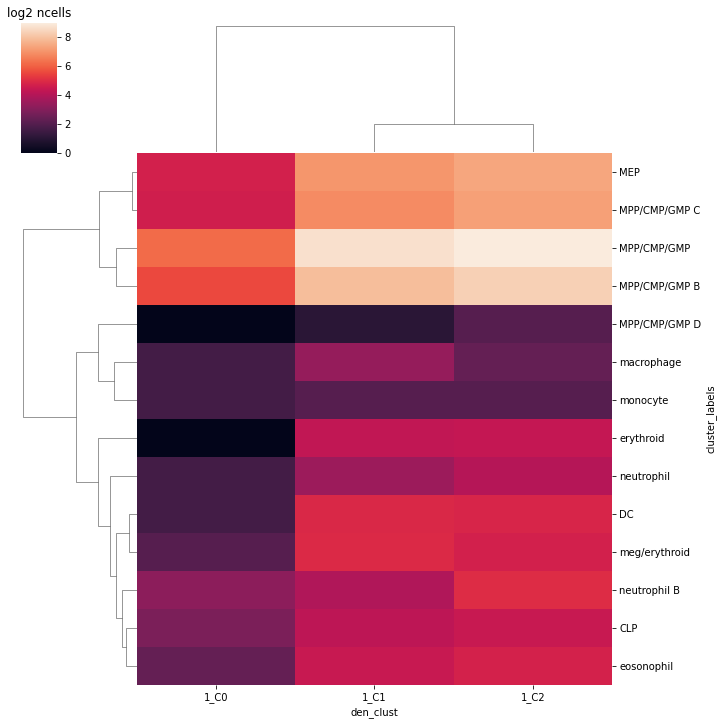

In [12]:
for d, val in cells_meta.groupby("donor"):
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
                                                             p_thresh=p_thresh, atac_col=atac_col, 
                                                              clone_col=clone_col)
    #cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes)

    curr_don_out = donor_out[int(d)]
    bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
    output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
    if output_df.shape[0] == 0:   
        g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
                       row_cluster=False)
        g.fig.suptitle("No groups were significant")
    else:
        g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
                       row_cluster=False)
    g.ax_heatmap.set(xlabel="Cluster ID")
    g.ax_cbar.set(title="-log10 p-value")
    plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
    init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
                                              clones=curr_clones, atac_cl=curr_atac_cl)
    
    shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
                                  n_shuffle=1000, to_parallel=True, n_cpus=24)

    out_all,out_min, out_cloneall, out_clonemin = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
                                                          curr_clone_map, atac_col, 
                                                          outdir=join(curr_don_out, "shuffle"))
    
    
    # plot just the counts
    curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
    g = sns.clustermap(curr_groups.pivot(index="cluster_labels",columns="den_clust", values="log2_count").fillna(0))
    plt.gca().set_title("log2 ncells")
    plt.savefig(join(curr_don_out, "ncells.png"))
    

In [13]:
shuffle.shape

(1000, 3, 14)

## B) Run using all donors as background

ic| len(global_min): 1000
ic| len(clone_min): 6
ic| len(clone_min): 6
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all): 6


Number of groups below p-val significance: 0
Number of groups below p-val significance: 0
clone all
axs 2
curr_thresh 3.148486599640748826e-11
curr_thresh 0.0
curr_thresh 1.4254597502372235676e-11
curr_thresh 0.0
curr_thresh 0.0
curr_thresh 0.0


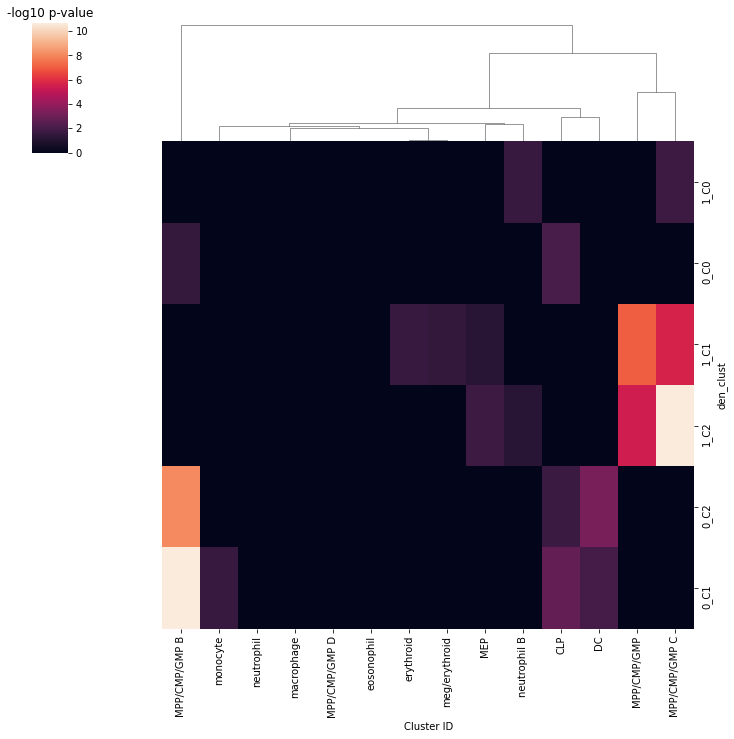

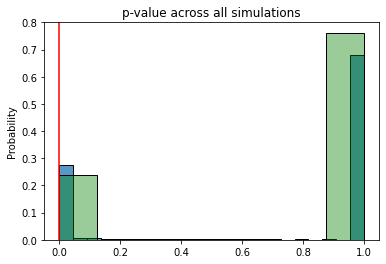

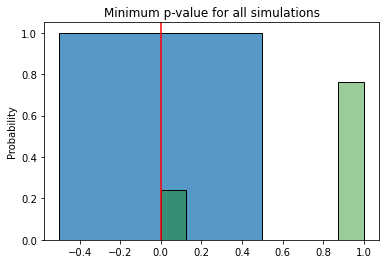

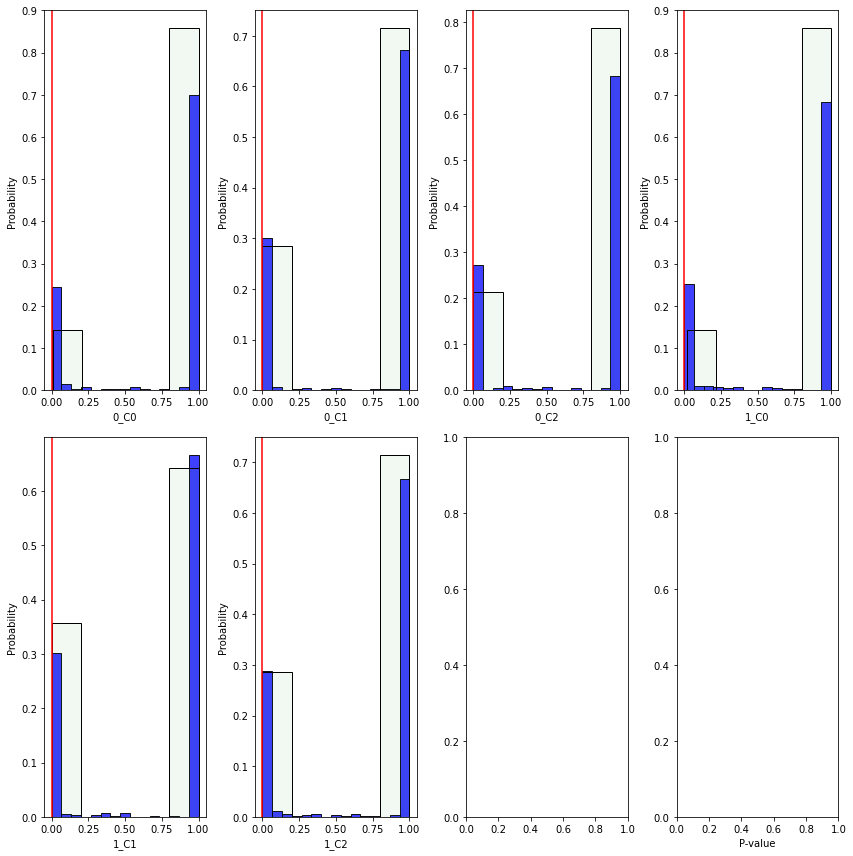

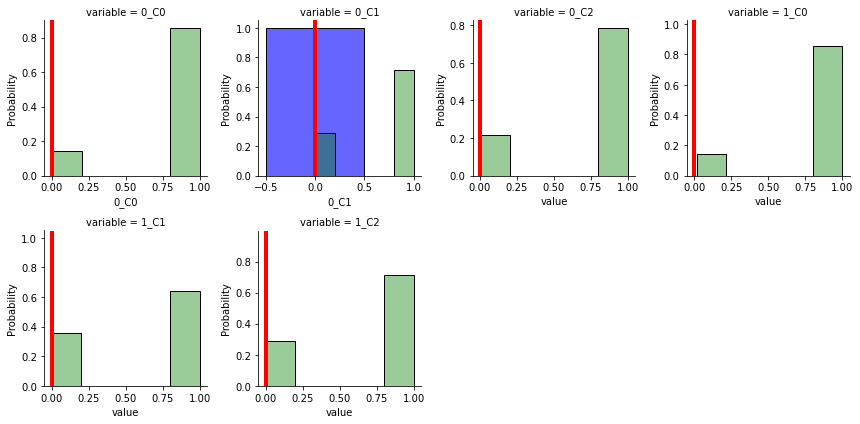

In [14]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl

output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)

bh_enrichment_df.to_csv(join(all_dir, "hypergeo_input_padjusted.csv"))
output_df.to_csv(join(all_dir, "hypergeo_input_padjusted_sigOnly.csv"))
    
g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
               row_cluster=False)

g.ax_heatmap.set(xlabel="Cluster ID")
g.ax_cbar.set(title="-log10 p-value")
plt.savefig(join(all_dir, "hypergeo_input_padjusted_sigOnly.png"))



## Run shuffle
init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
                                          clones=clones, atac_cl=atac_cl)

shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=1000, 
                              to_parallel=True, n_cpus=24)

out_all,out_min, out_cloneall, out_clonemin = cs.get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, 
                                                      outdir=sim_all_dir)

In [15]:
out_cloneall

{'0_C0': Series([], Name: 0_C0, dtype: bool),
 '0_C1': Series([], Name: 0_C1, dtype: bool),
 '0_C2': Series([], Name: 0_C2, dtype: bool),
 '1_C0': Series([], Name: 1_C0, dtype: bool),
 '1_C1': Series([], Name: 1_C1, dtype: bool),
 '1_C2': Series([], Name: 1_C2, dtype: bool)}

In [16]:
out_clonemin

{'0_C0': Series([], Name: 0_C0, dtype: bool),
 '0_C1': Series([], Name: 0_C1, dtype: bool),
 '0_C2': Series([], Name: 0_C2, dtype: bool),
 '1_C0': Series([], Name: 1_C0, dtype: bool),
 '1_C1': Series([], Name: 1_C1, dtype: bool),
 '1_C2': Series([], Name: 1_C2, dtype: bool)}

In [17]:
out_min[0]

,level_0,cluster_labels,p_val


In [18]:
out_all

(Empty DataFrame
 Columns: [level_0, cluster_labels, p_val]
 Index: [],
 0.0)

In [19]:
# global_min, clone_min, global_all, clone_all = cs.get_shuffle_results(shuffle, clones)

# out_all = plot_glob_all(global_all, bh_enrichment_df, p_thresh, out_f=None)
# plot_glob_min(bh_enrichment_df, global_min,p_thresh, out_f=None)
# plot_clone_min(bh_enrichment_df, clone_min, out_f=None)
# plot_clone_all(clone_all, bh_enrichment_df, p_thresh, out_f=None)

In [20]:

# def get_shuffle_results(shuffle, clones):
#     # a. Get the min for each run
#     # b. Get the min for each clone
#     # c. Get all values across all runs
#     # d. Get all values for each clone separatelyt

#     global_min = [i.min().min() for i in shuffle]
#     ic(len(global_min))
#     clone_min = {}
#     for curr_ind in clones.values:
#         clone_min[curr_ind] = [i[clone_map[curr_ind]].min() for i in shuffle]
#     ic(len(clone_min))


#     clone_min = {}
#     for curr_ind in clones.values:
#         clone_min[curr_ind] = [i[clone_map[curr_ind]].min() for i in shuffle]
#     ic(len(clone_min))


#     global_all=[]
#     for i in shuffle:
#         global_all.extend(i.flatten()) 
#     len(global_all)

#     clone_all={}
#     for curr_ind in clones.values:
#         clone_all[curr_ind] = []
#         for i in shuffle:
#             clone_all[curr_ind].extend(i[clone_map[curr_ind]])
#     ic(len(clone_all))
#     ic(len(clone_all[curr_ind]))

#     return global_min, clone_min, global_all, clone_all


# def plot_glob_all(global_all, bh_enrichment_df, p_thresh, out_f=None):
#     p_thresh = 0.1
#     curr_thresh = np.percentile(global_all, 100*p_thresh)
#     f,ax = plt.subplots()
#     sns.histplot(global_all, ax=ax,stat='probability')
#     sns.histplot(bh_enrichment_df.values.flatten(), color="green", stat='probability', alpha=0.4, ax=ax)
#     plt.axvline(curr_thresh, color='r')
#     group_vs_shuffle = bh_enrichment_df[bh_enrichment_df<curr_thresh]
#     sig_pairs = group_vs_shuffle.stack().reset_index().rename({"level_1":atac_col, 0:"p_val"}, axis=1)
#     print(f"Number of groups below p-val significance: {(sig_pairs.shape[0])}")
#     plt.title("p-value across all simulations")
#     sig_pairs = sig_pairs.sort_values("p_val")
#     if out_f is not None:
#         plt.savefig(out_f)
#     return sig_pairs, curr_thresh

# def plot_glob_min(bh_enrichment_df, global_min,p_thresh, out_f=None):
#     curr_thresh = np.percentile(global_min, 100*p_thresh)
#     f,ax = plt.subplots()
#     sns.histplot(global_min, ax=ax,stat='probability')
#     sns.histplot(bh_enrichment_df.values.flatten(), color="green", stat='probability', alpha=0.4, ax=ax)
#     plt.axvline(curr_thresh, color='r')
#     plt.title("Minimum p-value for all simulations")
#     group_vs_shuffle = bh_enrichment_df[bh_enrichment_df<curr_thresh]
#     sig_pairs = group_vs_shuffle.stack().reset_index().rename({"level_1":atac_col, 0:"p_val"}, axis=1)
#     print(f"Number of groups below p-val significance: {(sig_pairs.shape[0])}")
#     sig_pairs = sig_pairs.sort_values("p_val")

#     sig_pairs
#     if out_f is not None:
#         plt.savefig(out_f)
#     return sig_pairs, curr_thresh



# def plot_clone_all(clone_all, bh_enrichment_df, p_thresh, out_f=None):
#     f, axs = plt.subplots(nrows=int(np.ceil(bh_enrichment_df.shape[0]/4)), ncols=4, figsize=(12,12), 
#                           sharex=False, sharey=False)

#     clone_min_sig = {}
#     for i, ind in enumerate(bh_enrichment_df.index):
#         curr_row, curr_col = int(np.floor(i/4)), i%4
#         data = clone_all[ind]
#         curr_thresh = np.percentile(clone_all[ind], 100*p_thresh)
#         group_vs_shuffle = bh_enrichment_df.loc[ind]<curr_thresh
#         sig_pairs = group_vs_shuffle[group_vs_shuffle] #.stack().reset_index().rename({"level_1":atac_col, 0:"p_val"}, axis=1)
#         #sig_pairs = sig_pairs.sort_values("p_val")
#     #     sig_pairs
#         clone_min_sig[ind] = sig_pairs

#         sns.histplot(data=data, stat='probability', color='blue', ax=axs[curr_row,curr_col])
#         sns.histplot(bh_enrichment_df.loc[ind],stat='probability', color='green', alpha=0.05, ax=axs[curr_row,curr_col])
#         #sns.histplot(data=real_df.loc[data["variable"][0]], x='value',stat='probability', color='green', alpha=0.05)
#         plt.xlabel("P-value")
#         #print(real_df.loc[data["variable"][0]])
#         #plt.title(ind)
#         print('curr_thresh', curr_thresh)
#         axs[curr_row,curr_col].axvline(curr_thresh, color='r')

#     f.tight_layout()
#     if out_f is not None:
#         plt.savefig(out_f)
#     return clone_min_sig


# def plot_clone_min(bh_enrichment_df, clone_min, out_f=None):
#     clone_min_sig = {}

#     g = sns.FacetGrid(pd.DataFrame(clone_min).melt(), col="variable", col_wrap=4, sharex=False, sharey=False)
#     g.map_dataframe(sns.histplot, x="value", stat='probability', color='blue', alpha=0.6)

#     if out_f is not None:
#         plt.savefig(out_f)
        
        
#     for i, ind in enumerate(bh_enrichment_df.index):
#         data = clone_min[ind]
#         curr_thresh = np.percentile(clone_min[ind], 100*p_thresh)
#         group_vs_shuffle = bh_enrichment_df.loc[ind]<curr_thresh
#         sig_pairs = group_vs_shuffle[group_vs_shuffle] 
#         clone_min_sig[ind] = sig_pairs
#         g.axes_dict[ind].axvline(curr_thresh, color='red', linewidth=4)
#         sns.histplot(bh_enrichment_df.loc[ind], stat='probability', color='green', alpha=0.4, ax=g.axes_dict[ind])
#     return clone_min_sig


In [21]:
# def wrap_out():
#     out_glob_all = plot_glob_all(global_all, bh_enrichment_df, p_thresh, out_f=None)
#     out_glob_min =plot_glob_min(bh_enrichment_df, global_min,p_thresh, out_f=None)
#     out_clone_all =plot_clone_all(clone_all, bh_enrichment_df, p_thresh, out_f=None)
#     out_clone_min =plot_clone_min(bh_enrichment_df, clone_min, out_f=None)
#     return

In [22]:
# def plot_overlay_hist(*args, **kwargs):
#     data = kwargs.pop("data").reset_index()
#     real_df = args[0]
#     #print(data.head())
#     #print('var', data["variable"][0])
#     #print(real_df.loc[data["variable"][0]])
#     #print('real_df', real_df)
#     #print(real_df.loc[data["variable"][0]])
#     ax = plt.gca()
#     sns.histplot(data=data,x="value", stat='probability', color='blue', ax=ax)
#     sns.histplot(real_df.loc[data["variable"][0]],stat='probability', color='green', alpha=0.05, ax=ax)
#     #sns.histplot(data=real_df.loc[data["variable"][0]], x='value',stat='probability', color='green', alpha=0.05)
#     plt.xlabel("P-value")
#     #print(real_df.loc[data["variable"][0]])
#     plt.title(data["variable"][0])
#     return
    
# ## clone_all
# g = sns.FacetGrid(pd.DataFrame(clone_all).melt(), col="variable", col_wrap=4, sharex=False, sharey=False)
# #g.map_dataframe(sns.histplot, x="value", stat='probability', color='blue')
# g.map_dataframe(plot_overlay_hist, bh_enrichment_df)

## no parallel

In [23]:
# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=100)

# ## a. Get the min for each run
# ## b. Get the 
# global_min = [i.min().min() for i in shuffle]
# ic(len(global_min))
# clone_min = [i.min(axis=1) for i in shuffle]
# ic(len(clone_min))

# clone_all={}
# for curr_ind in shuffle[0].index:
#     clone_all[curr_ind] = []
#     for i in shuffle:
#         clone_all[curr_ind].extend(list(i.loc[curr_ind].values))
# ic(len(clone_all))
# ic(len(clone_all[0]))

# global_all=[]
# for i in shuffle:
#     global_all.extend(i.values.flatten()) 
# len(global_all)

In [24]:
# output_df, bh_enrichment_df = pipeline_groups_hypergeo(groups, clones, atac_cl, sizes)

# g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                row_cluster=False)
# g.ax_heatmap.set(xlabel="Cluster ID")
# g.ax_cbar.set(title="-log10 p-value")